In [63]:
!pip install seaborn

!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-d2svnqzr
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-d2svnqzr
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0c324052667ff024223f2b8099f0eb89eca4e4077_-cp36-none-any.whl size=126415 sha256=3b229634ae84b0649607cd2ef36446203e211281007b740129ce4c9c92f2313d
  Stored in directory: /tmp/pip-ephem-wheel-cache-o_mcde_w/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [64]:
from __future__ import absolute_import, division, print_function

import pathlib
import matplotlib.pyplot as plt


import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.2.0


In [65]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [66]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [67]:
column_names = ['MPG', 'Cylinder', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(dataset_path, names=column_names, na_values="?", comment='\t', sep = " ", skipinitialspace=True)

dataset.tail()

,MPG,Cylinder,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [68]:
dataset.isna().sum()

MPG             0
Cylinder        0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [69]:
dataset = dataset.dropna()

In [70]:
# origin = dataset.pop('Origin')

In [71]:
# dataset['USA'] = (origin == 1)*1.0
# dataset['Europe'] = (origin == 2)*1.0
# dataset['Japan'] = (origin == 3)*1.0
# OR we can also map it using this.
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='') #printing function for above statement with the combination of dataset.tail()
dataset.tail()

,MPG,Cylinder,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [72]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

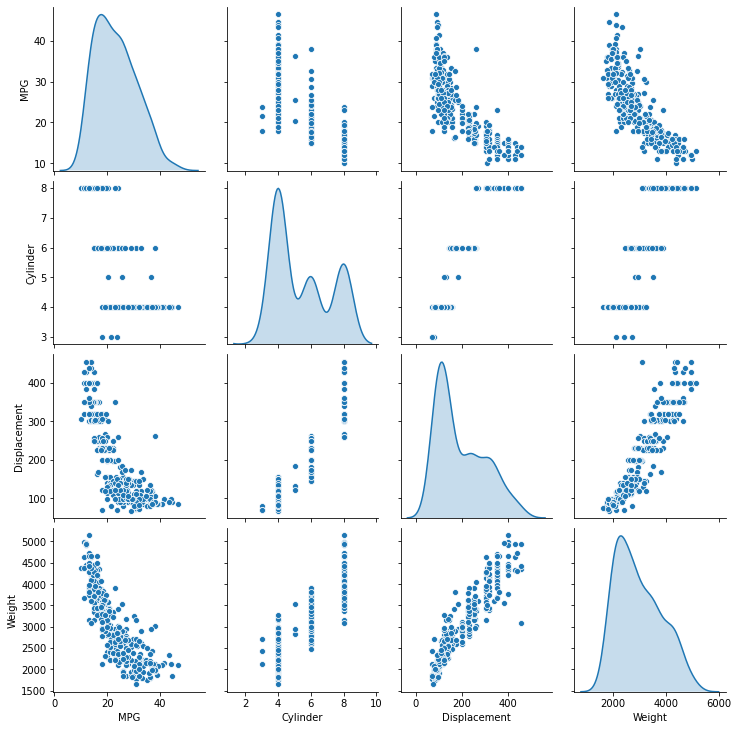

In [73]:
sns.pairplot(train_dataset[["MPG", "Cylinder", "Displacement", "Weight"]], diag_kind="kde")

In [74]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinder,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


As the range of the above plotted data is too vast that is not good for our ml model so we will normalize our data for better ranges.

In [75]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

In [76]:
def norm(x):
  return (x - train_stats['mean'])/train_stats['std']

norm_train_data = norm(train_dataset)
norm_test_data = norm(test_dataset)


In [77]:
def build_model():
  model = keras.Sequential([
          layers.Dense(64, activation=tf.nn.relu, input_shape = [len(train_dataset.keys())]),
          layers.Dense(64, activation=tf.nn.relu),# Linear activation for regression model.
          layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss = 'mse',
                optimizer = optimizer,
                metrics = ['mae', 'mse'])# used to see how well ouyr model is doing 
  return model

In [78]:
model = build_model()

In [79]:
model.summary() # it is used to view summary of our model keras makes it easy to do this !!

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Trying our model out here for a small number of features to see if its working correctly or needs a little more configuration.

In [80]:
example_batch = norm_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.8069584 ],
       [-0.05553406],
       [-0.25535035],
       [-0.08398078],
       [-0.39525282],
       [-0.01552697],
       [-0.38498014],
       [ 0.23964956],
       [-0.17065737],
       [-0.7015259 ]], dtype=float32)

As it is not giving out any errors we can proceed further, Now, training our model.

In [81]:
# class PrintDot(keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs):
#     if epoch % 100 == 0: print('')
#     print('.', end='')

EPOCHS = 1000

history = model.fit(
    norm_train_data, train_labels, 
    epochs = EPOCHS, validation_split = 0.2, verbose = 0, # validation split is used to split 20% of our data into a validation set and is used to validate/train our data while training
    #callbacks = [PrintDot()]
    callbacks=[tfdocs.modeling.EpochDots()] # can also use this after using this function we do not need to create above PrintDot finction to know that our model is training
)


Epoch: 0, loss:584.6368,  mae:22.9186,  mse:584.6368,  val_loss:579.3748,  val_mae:22.7435,  val_mse:579.3748,  
....................................................................................................
Epoch: 100, loss:6.2194,  mae:1.7397,  mse:6.2194,  val_loss:9.3301,  val_mae:2.2607,  val_mse:9.3301,  
....................................................................................................
Epoch: 200, loss:5.3406,  mae:1.5880,  mse:5.3406,  val_loss:8.5916,  val_mae:2.2804,  val_mse:8.5916,  
....................................................................................................
Epoch: 300, loss:4.7937,  mae:1.5070,  mse:4.7937,  val_loss:9.2150,  val_mae:2.3462,  val_mse:9.2150,  
....................................................................................................
Epoch: 400, loss:4.3970,  mae:1.4031,  mse:4.3970,  val_loss:9.3162,  val_mae:2.3411,  val_mse:9.3162,  
..............................................................

Visualizing out data using the history object.

In [82]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,3.099742,1.066665,3.099742,10.363338,2.453785,10.363338,995
996,3.080411,1.058959,3.080411,10.420660,2.417146,10.420660,996
997,3.224867,1.062494,3.224867,10.527851,2.391124,10.527851,997
998,3.079221,1.076851,3.079221,10.550035,2.395570,10.550035,998
999,3.142325,1.081819,3.142325,10.416934,2.382451,10.416934,999


In above result our loss was going really up to look at whats going on we will be using matplotlib to basically plot our data and look where it is acting up.

In [83]:
# import matplotlib.pyplot as plt
# def plot_history(history):
#   hist = pd.DataFrame(history.history)
#   hist['epoch'] = history.epoch

#   plt.figure()
#   plt.xlabel('Epoch')
#   plt.ylabel('Mean Abs Error [MPG]')
#   plt.plot(hist['epoch'], hist['mae'],
#            label = 'Train Error')
#   plt.plot(hist['epoch'], hist['val_mae'],
#            label = 'Val Error')
#   plt.legend()
#   plt.ylim([0,5])

#   plt.figure()
#   plt.xlabel('Epoch')
#   plt.ylabel('Mean Square Error [$MPG^2$]')
#   plt.plot(hist['epoch'], hist['mse'],
#            label = 'Train Error')
#   plt.plot(hist['epoch'], hist['val_mse'],
#            label = 'Val Error')
#   plt.legend()
#   plt.ylim([0, 20])

# plot_history(history)

As we can see the orange plotted portion is going up and this is the case of classic overfitting to stop this from happening we are using EarlyStopping callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training. This callback automatically stop training when the validation score doesn't improve.
but first lets look at another plotting function for better understanding.

We can also visualize above data using tfdocs plotter. Like shown Below.

In [84]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

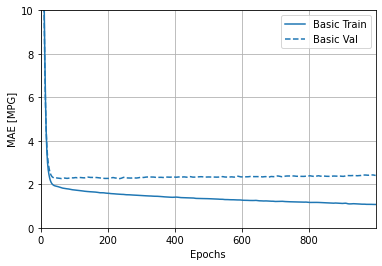

In [85]:
plotter.plot({'Basic': history}, metric = 'mae')
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

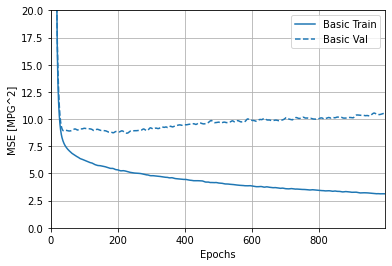

In [86]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

EARLYSTOPPING CALLBACK FOR OUR MODEL.

In [87]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(norm_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:559.5485,  mae:22.4476,  mse:559.5485,  val_loss:547.6815,  val_mae:22.1233,  val_mse:547.6815,  
...................................................

Text(0, 0.5, 'MAE [MPG]')

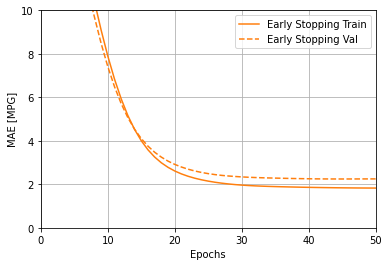

In [88]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [90]:
loss, mae, mse = model.evaluate(norm_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.6373 - mae: 1.7791 - mse: 5.6373
Testing set Mean Abs Error:  1.78 MPG


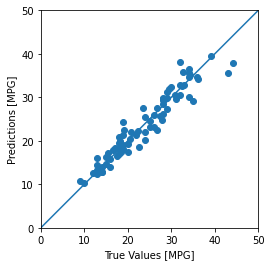

In [92]:
test_predictions = model.predict(norm_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

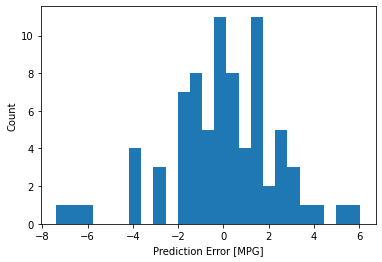

In [93]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")